In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt


 ## Function to extract MFCC

In [3]:
def extract_mfcc(file_path, n_mfcc=13, max_len=50):
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=None)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    
    # Pad / truncate to fixed length (so all have the same shape)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0), (0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc


In [4]:
data_path = "C:\\Users\\HP\\Downloads\\archive (6)"  # e.g. "dataset/"
X = []
y = []

for label in os.listdir(data_path):  # each folder is a letter (alif, baa, ...)
    folder = os.path.join(data_path, label)
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith(".wav"):
                file_path = os.path.join(folder, file)
                mfcc = extract_mfcc(file_path)
                X.append(mfcc)
                y.append(label)  # store the letter as label


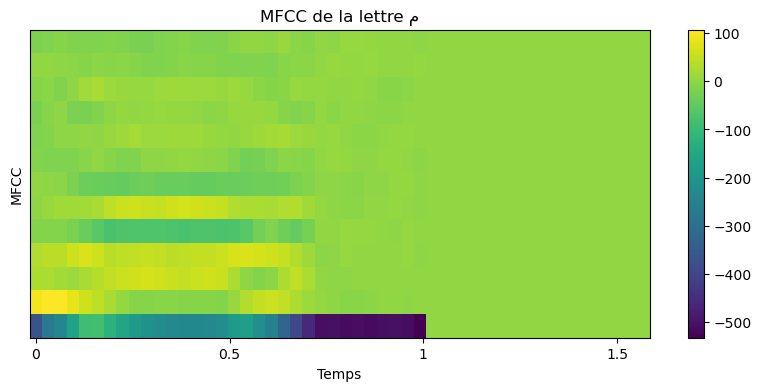

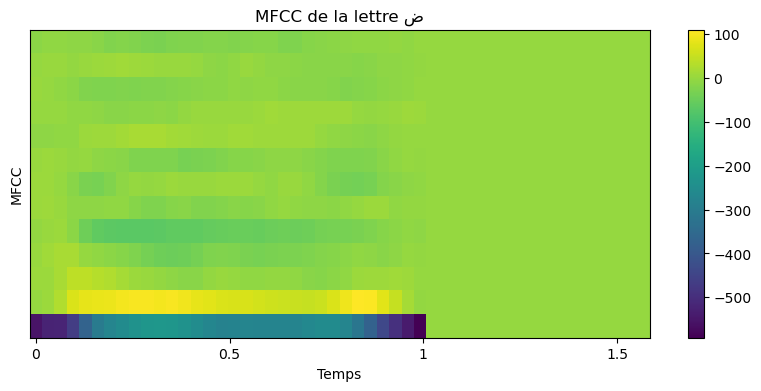

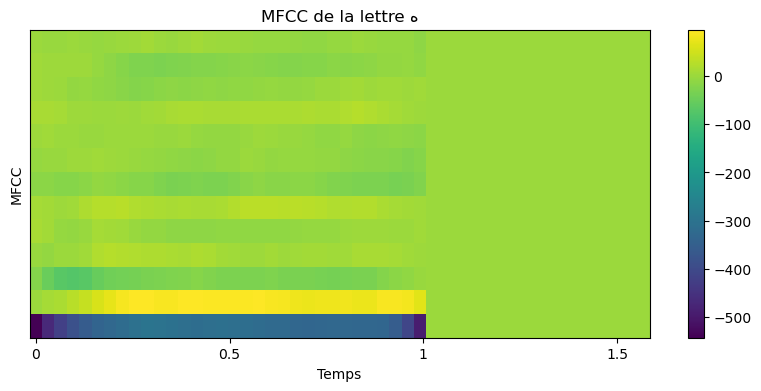

In [7]:
import matplotlib.pyplot as plt
import librosa.display
import random

# Choisir quelques indices aléatoires dans X pour illustrer
indices = random.sample(range(len(X)), 3)  # par exemple 3 exemples

for i, idx in enumerate(indices):
    mfcc = X[idx]
    label = y[idx]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=16000, cmap='viridis')  # bleu-vert doux
    plt.colorbar()
    plt.title(f"MFCC de la lettre {label}")
    plt.xlabel("Temps")
    plt.ylabel("MFCC")
    plt.show()


## Split into train/test sets

In [47]:
# X = []  # list of MFCC arrays
# y = []  # list of labels corresponding to each sample

X = np.array(X, dtype="float32")
y = np.array(y)

# -----------------------------
# 2️Encode labels
# -----------------------------
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # integers 0..27
y_categorical = to_categorical(y_encoded)   # one-hot encoding

# -----------------------------
# Normalize X
# -----------------------------
X = X / np.max(X)  # scale MFCCs to 0-1

# -----------------------------
# Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

# -----------------------------
# Add channel dimension for CNN
# -----------------------------
X_train = np.expand_dims(X_train, -1)  # (num_samples, 13, 50, 1)
X_test = np.expand_dims(X_test, -1)    # (num_samples, 13, 50, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (12544, 13, 50, 1)
y_train shape: (12544, 28)
X_test shape: (3136, 13, 50, 1)
y_test shape: (3136, 28)


## CNN Model 

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Nombre de classes
num_classes = y_categorical.shape[1]

# -----------------------------
# Build the CNN model
# -----------------------------
model = Sequential([
    # 1️⃣ Convolution + Pooling
    Conv2D(32, (3,3), activation='relu', input_shape=(13,50,1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # 2️⃣ Convolution plus profonde
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # 3️⃣ Convolution encore plus profonde
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),  # régularisation supplémentaire

    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -----------------------------
# EarlyStopping
# -----------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,              # attend 5 epochs sans amélioration
    restore_best_weights=True
)

# -----------------------------
# Train the model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 13, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 13, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 6, 25, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 6, 25, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 6, 25, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 3, 12, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 3, 12, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 3, 12, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 1, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 326,940 (1.25 MB)

 Trainable params: 326,492 (1.25 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.0762 - loss: 3.2375 - val_accuracy: 0.1636 - val_loss: 2.9520
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1973 - loss: 2.6326 - val_accuracy: 0.3686 - val_loss: 1.9440
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.3194 - loss: 2.0683 - val_accuracy: 0.5048 - val_loss: 1.3838
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4530 - loss: 1.5823 - val_accuracy: 0.6291 - val_loss: 1.0769
Epoch 5/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5534 - loss: 1.2602 - val_accuracy: 0.7012 - val_loss: 0.8339
Epoch 6/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6312 - loss: 1.0403 - val_accuracy: 0.7844 - val_loss: 0.6439
Epoch 7/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6806 - loss: 0.8833 - val_accuracy: 0.8224 - val_loss: 0.4965
Epoch 8/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7323 - loss: 0

In [72]:
model.save("mfcc_cnn_model.h5")

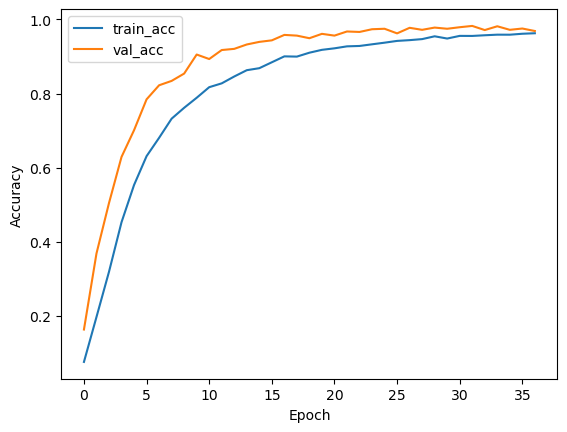

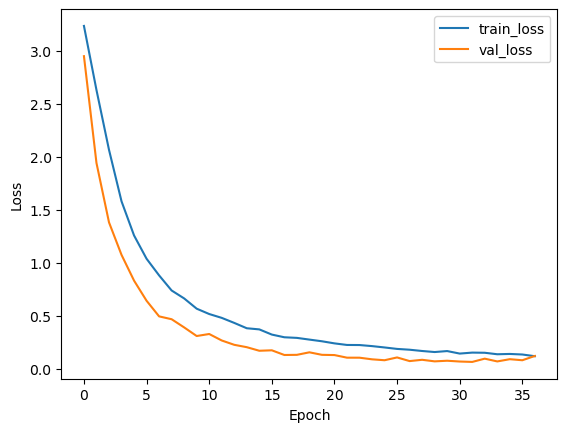

In [74]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [75]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 98.25%
Test Loss: 0.0667


In [76]:
# Predict probabilities for each class
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot test labels back to integers
y_true_classes = np.argmax(y_test, axis=1)


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   


In [80]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print(classification_report(y_true_classes, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      0.98      0.99       112
           2       0.98      0.95      0.96       112
           3       0.96      0.96      0.96       112
           4       1.00      0.99      1.00       112
           5       0.99      0.98      0.99       112
           6       1.00      1.00      1.00       112
           7       0.96      0.98      0.97       112
           8       0.98      0.96      0.97       112
           9       0.89      1.00      0.94       112
          10       1.00      1.00      1.00       112
          11       1.00      0.99      1.00       112
          12       0.99      0.99      0.99       112
          13       1.00      0.99      1.00       112
          14       0.96      0.99      0.97       112
          15       0.97      0.91      0.94       112
          16       1.00      0.92      0.96       112
          17       1.00    

In [53]:
sample = X_test[0]               # shape (13,50,1)
sample = np.expand_dims(sample, 0)  # add batch dimension → shape (1,13,50,1)

pred_probs = model.predict(sample)
pred_class = np.argmax(pred_probs)
pred_label = label_encoder.inverse_transform([pred_class])
print(f"Predicted label: {pred_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Predicted label: ص


In [78]:
true_class = np.argmax(y_test[0])
true_label = label_encoder.inverse_transform([true_class])
print(f"True label: {true_label[0]}")


True label: ص


In [79]:
import pickle

# Save the label encoder for later use
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
